# Thesis Study 2

## Goals of Study 2

The second part of the study has two primary goals:

1.  To assess the impact of including surrounding textual **context** when generating chart interpretations on the retrieval performance of a Retrieval-Augmented Generation (RAG) system.
2.  To evaluate whether the performance impact observed in Study 1 holds true when using a smaller, more efficient Vision-Language Model (VLM).

This demonstration showcases the workflow of creating separate vector store collections, embedding chart interpretations generated with and without context, adding them to their respective collections, and then querying the stores with example interpretations to obtain cosine similarity scores.

## Models and Methodology

*   **Chart Interpretation Model:** [**InternVL3.5 1B**](https://huggingface.co/OpenGVLab/InternVL3_5-1B-HF), a state-of-the-art, open-sourced 1B parameter VLM capable of running on consumer machines. 
*   **Text Embedding Model:** [**BAAI/bge-base-en-v1.5**](https://huggingface.co/BAAI/bge-base-en-v1.5), a top-performing and widely-used open-source model for generating high-quality text embeddings.
*   **Vector Database:** **ChromaDB**, a modern, open-source vector store used to index and retrieve the generated chart interpretations.

**Answering Goal 1**
    - The assessment will be based on cosine similarity scores produced by the retrieval pipeline. After aggregation, a statistical test will be conducted to determine whether the average scores differ significantly between the two conditions.

**Answering Goal 2**
    - The hypothesis is that chart interpretations generated with surrounding context will, on average, achieve higher cosine similarity scores with the queries. To avoid bias, these queries will be generated by the evaluator prior to producing the chart interpretations.


In [5]:
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from embeddings.embeddings import EmbeddingsFactory
from ingestion.ingestion import Ingestor
from retrieval.retriever import Retriever

## Loading the Data
We load the generated chart interpretations and user-defined queries from their respective files and prepare the metadata for ingestion.

In [ ]:
### --- Loading the Data --- ###
# Loading the dataset and separating interpretations based on context availability
# Get the absolute path to the notebook's directory
notebook_dir = Path.cwd()
repo_root = notebook_dir.parent.parent

# Build absolute paths
interpretations_path = repo_root / 'study2' / 'outputs' / 'all_responses.csv'
df_path = repo_root / 'study2' /  'data' / 'processed' / 'img-context-df.csv'

# Load data with absolute paths
interpretations = pd.read_csv(interpretations_path)
df = pd.read_csv(df_path)

# Rest of your code remains the same
with_context = interpretations['with_context'].tolist()
without_context = interpretations['without_context'].tolist()
item_ids = interpretations["item_id"].tolist()
img_paths = df["image_path_1"].tolist()

In [12]:
# Create the metadata & Load queries
def create_metadata(item_ids, img_paths):
    metadata = []
    for item_id, img_path in zip(item_ids, img_paths):
        metadata.append({
            "target_doc": item_id,
            "image_path": img_path
        })
    return metadata

metadata = create_metadata(item_ids, img_paths)

queries_path = repo_root / 'study2' / 'data' / 'raw' / 'queries.json'

# Load the queries from the JSON file
with open(queries_path, 'r') as f:
    queries = json.load(f)
    
print(f"Loaded {len(queries)} queries from the JSON file.")

Loaded 61 queries from the JSON file.


## Data Ingestion

With the chart interpretations prepared, we now use a BGE embedding model to ingest them into two separate vector database collections: 

* `with_context`
* `without_context`

In [13]:
### --- Ingestion --- ###
# Initialize the embedding model & ingestor
bge_embedder = EmbeddingsFactory.create(kind="bge")
ingestor = Ingestor(embedder=bge_embedder)

# Ingest the data into two separate collections
print("--- Ingesting documents with context ---")
ingestor.ingest(
    texts=with_context,
    persist_directory="./vector_db",
    collection_name="with_context",
    metadata=metadata
)

print("\n--- Ingesting documents without context ---")
ingestor.ingest(
    texts=without_context,
    persist_directory="./vector_db",
    collection_name="without_context",
    metadata=metadata
)

print("\nIngestion complete!")

/home/mlazar/projects/testing/UvA-Thesis/study2/src/embeddings/embeddings.py:16: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self._emb = HuggingFaceBgeEmbeddings(
/home/mlazar/projects/testing/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The 8-bit optimizer is not available on your device, only available on CUDA for now.


--- Ingesting documents with context ---
Successfully ingested 61 documents into collection 'with_context'.

--- Ingesting documents without context ---
Successfully ingested 61 documents into collection 'without_context'.

Ingestion complete!


## Retrieval

Now that the data is ingested, the next step is to query the vector store. We will use the `Retriever` class to fetch the most relevant documents for our test queries and their corresponding cosine similarity scores.

In [14]:
### --- Retrieval & Evaluation --- ###
# Initialize the retriever (assumes bge_embedder is defined from a previous cell)
retriever = Retriever(embedder=bge_embedder, persist_directory="./vector_db")

# Evaluation Loop
evaluation_data = []
K = 61  # How many documents to retrieve to check the rank

# Loop through each query object
for query_item in queries:
    query_text = query_item['query']
    target_image_path = query_item['image_path']
    
    # This dictionary will hold the results for a single row in our final DataFrame
    result_row = {
        "image_path": target_image_path,
        "query": query_text,
    }

    # Evaluate against both collections
    for collection_name in ["with_context", "without_context"]:
        
        # Retrieve the top K documents for the query
        retrieved_docs = retriever.retrieve_with_scores(
            query=query_text,
            collection_name=collection_name,
            k=K
        )
        
        # Default values if the target is not found in the top K
        target_rank = -1
        target_similarity = 0.0

        # Find the rank and similarity of the document with the matching image_path
        for i, (doc, score) in enumerate(retrieved_docs):
            if doc.metadata.get('image_path') == target_image_path:
                target_rank = i + 1
                target_similarity = score
                break  # Found it, no need to search further
        
        # Add the results for this collection to our row dictionary
        result_row[f"{collection_name}_rank"] = target_rank
        result_row[f"{collection_name}_similarity"] = target_similarity

    # Add the completed row to our list of results
    evaluation_data.append(result_row)
    
# Convert the list of dictionaries into a clean pandas DataFrame
final_results_df = pd.DataFrame(evaluation_data)

# Display the final, comprehensive results table
final_results_df

,image_path,query,with_context_rank,with_context_similarity,without_context_rank,without_context_similarity
0,/home/mlazar/projects/thesis/tbp_articles/arxi...,What is the fourth step of the WERSA algorithm?,1,0.280222,1,0.102758
1,/home/mlazar/projects/thesis/tbp_articles/arxi...,Help me understand how the KELPS model is used...,1,0.346229,1,0.493795
2,/home/mlazar/projects/thesis/tbp_articles/arxi...,What's the difference between TE and TM Polari...,1,0.294136,1,0.534047
3,/home/mlazar/projects/thesis/tbp_articles/arxi...,"What was the timeframe, between which Active d...",1,0.272575,1,0.296797
4,/home/mlazar/projects/thesis/tbp_articles/arxi...,How do the 87A-like supernovae differ from IIb...,1,0.515293,1,0.253979
...,...,...,...,...,...,...
56,/home/mlazar/projects/thesis/tbp_articles/soci...,Is there a difference between sighted and cong...,1,0.603205,1,0.521769
57,/home/mlazar/projects/thesis/tbp_articles/soci...,What three pillars are the departmental practi...,1,0.374049,1,0.379505
58,/home/mlazar/projects/thesis/tbp_articles/soci...,How did the responses vary with pitch and dura...,1,0.298192,3,0.121347
59,/home/mlazar/projects/thesis/tbp_articles/soci...,What three principles are important in guiding...,1,0.390006,1,0.286571


## Analysis of Retrieval Performance

Now that the evaluation is complete, we have a comprehensive `final_results_df` DataFrame. This dataset contains the results for each query against both of our collections. Each row includes:

*   The `query` text and its corresponding `image_path`.
*   The retrieval `rank` of the target document for both the `with_context` and `without_context` collections.
*   The cosine `similarity` score of the target document for both collections.

In the following steps, we will perform some basic descriptive statistics on these results and then conduct a paired t-test to determine if the observed differences in similarity scores and ranks between the two collections are statistically significant.

In [15]:
### --- Basic Descriptive Statistics --- ###
# Calculate total number of queries
total_queries = len(final_results_df)

# Count how many times with_context similarity was higher
higher_sim_count = (final_results_df['with_context_similarity'] > final_results_df['without_context_similarity']).sum()

# Count the number of Top-1 hits for each collection
with_context_top1_count = (final_results_df['with_context_rank'] == 1).sum()
without_context_top1_count = (final_results_df['without_context_rank'] == 1).sum()

# Count the number of times the target document was not top 1
absence_top1_count = ((final_results_df['with_context_rank'] != 1) & (final_results_df['without_context_rank'] != 1)).sum() # in either collection
absence_with_context_count = (final_results_df['with_context_rank'] != 1).sum() # in with_context collection
absence_without_context_count = (final_results_df['without_context_rank'] != 1).sum() # in without_context collection


# Display the comprehensive summary
print("--- Comprehensive Evaluation Summary ---")
print(f"Total Queries: {total_queries}\n")

print("--- Similarity Comparison ---")
print(f"'with_context' had higher similarity: {higher_sim_count} / {total_queries} times ({higher_sim_count/total_queries:.2%})\n")

print("--- Top-1 Absence ---")
print(f"'with_context' did NOT have the target document as Top-1:    {absence_with_context_count} / {total_queries} times ({absence_with_context_count/total_queries:.2%})")
print(f"'without_context' did NOT have the target document as Top-1: {absence_without_context_count} / {total_queries} times ({absence_without_context_count/total_queries:.2%})")
print(f"Neither collection had the target document as Top-1: {absence_top1_count} / {total_queries} times ({absence_top1_count/total_queries:.2%})\n")

print("--- Top-1 Hit Count ---")
print(f"'with_context' rank was 1:    {with_context_top1_count} / {total_queries} times ({with_context_top1_count/total_queries:.2%})")
print(f"'without_context' rank was 1: {without_context_top1_count} / {total_queries} time ({without_context_top1_count/total_queries:.2%})\n")

--- Comprehensive Evaluation Summary ---
Total Queries: 61

--- Similarity Comparison ---
'with_context' had higher similarity: 33 / 61 times (54.10%)

--- Top-1 Absence ---
'with_context' did NOT have the target document as Top-1:    4 / 61 times (6.56%)
'without_context' did NOT have the target document as Top-1: 6 / 61 times (9.84%)
Neither collection had the target document as Top-1: 2 / 61 times (3.28%)

--- Top-1 Hit Count ---
'with_context' rank was 1:    57 / 61 times (93.44%)
'without_context' rank was 1: 55 / 61 time (90.16%)



--- Checking Paired T-Test Assumption: Normality of Differences ---


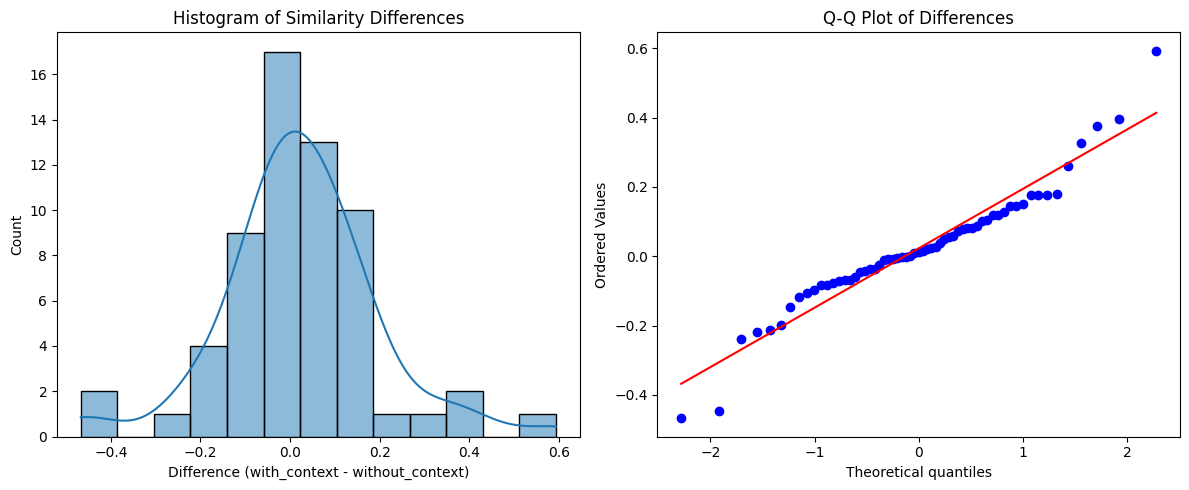


--- Shapiro-Wilk Test for Normality ---
Test Statistic: 0.9464
P-value: 0.0097
Conclusion: The p-value is < 0.05. We reject the null hypothesis.
The differences do not appear to be normally distributed.
A non-parametric alternative like the Wilcoxon signed-rank test might be more appropriate.


In [16]:
### --- Checking Assumptions for Paired T-Test --- ###
# We need to check if the differences between the paired samples are approximately normally distributed.
differences = final_results_df['with_context_similarity'] - final_results_df['without_context_similarity']

print("--- Checking Paired T-Test Assumption: Normality of Differences ---")

# --- Visual Inspection ---
# We'll create a histogram and a Q-Q plot side-by-side.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of the differences
sns.histplot(differences, kde=True, ax=ax1)
ax1.set_title('Histogram of Similarity Differences')
ax1.set_xlabel('Difference (with_context - without_context)')

# Q-Q (Quantile-Quantile) plot
stats.probplot(differences, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot of Differences')

plt.tight_layout()
plt.show()


# --- Formal Statistical Test (Shapiro-Wilk) ---
# The null hypothesis (H0) of this test is that the data is normally distributed.
shapiro_stat, shapiro_p_value = stats.shapiro(differences)

print("\n--- Shapiro-Wilk Test for Normality ---")
print(f"Test Statistic: {shapiro_stat:.4f}")
print(f"P-value: {shapiro_p_value:.4f}")

# Interpretation of the Shapiro-Wilk test
if shapiro_p_value > 0.05:
    print("Conclusion: The p-value is > 0.05. We fail to reject the null hypothesis.")
    print("The differences appear to be normally distributed, so the t-test is appropriate.")
else:
    print("Conclusion: The p-value is < 0.05. We reject the null hypothesis.")
    print("The differences do not appear to be normally distributed.")
    print("A non-parametric alternative like the Wilcoxon signed-rank test might be more appropriate.")

In [17]:
# --- Paired T-test on Cosine Similarity Scores ---

# Extract the two paired samples of similarity scores
similarity_with_context = final_results_df['with_context_similarity']
similarity_without_context = final_results_df['without_context_similarity']

# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(similarity_with_context, similarity_without_context)
w_statistic, wp_value = stats.wilcoxon(similarity_with_context, similarity_without_context, alternative="two-sided")

# Print the core results
print(f"Null Hypothesis: There is no difference in similarity scores between 'with_context' and 'without_context'.")

print("\n-- Average scores for both conditions --")
print(f"Average cosine similarity (with_context): {similarity_with_context.mean():.4f}")
print(f"Average cosine similarity (without_context): {similarity_without_context.mean():.4f}")
print("\n-- Median scores for both conditions --")
print(f"Median cosine similarity (with_context): {similarity_with_context.median():.4f}")
print(f"Median cosine similarity (without_context): {similarity_without_context.median():.4f}")

print("\n--- Paired T-test for Cosine Similarity ---")
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

print("\n--- Wilcoxon Signed-Rank Test for Cosine Similarity ---")
print(f"W-statistic: {w_statistic:.4f}")
print(f"P-value: {wp_value:.4f}")

print("\n--- Interpretation of Results ---")
if p_value < 0.05 and wp_value < 0.05:
    print("Result: The difference in similarity scores is statistically significant.")
else:
    print("Result: The difference in similarity scores is not statistically significant.")

Null Hypothesis: There is no difference in similarity scores between 'with_context' and 'without_context'.

-- Average scores for both conditions --
Average cosine similarity (with_context): 0.3357
Average cosine similarity (without_context): 0.3126

-- Median scores for both conditions --
Median cosine similarity (with_context): 0.3198
Median cosine similarity (without_context): 0.3027

--- Paired T-test for Cosine Similarity ---
T-statistic: 1.0376
P-value: 0.3036

--- Wilcoxon Signed-Rank Test for Cosine Similarity ---
W-statistic: 785.0000
P-value: 0.2490

--- Interpretation of Results ---
Result: The difference in similarity scores is not statistically significant.
